In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dem_stitcher.stitcher import download_dem
import rasterio
import matplotlib.pyplot as plt
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
from pathlib import Path
from dem_stitcher.rio_tools import crop_profile_from_coord_bounds
from dem_stitcher.stitcher import merge_tiles
from rasterio import default_gtiff_profile
import numpy as np

In [3]:
site = 'aleutian' # 'bay_area' or 'aleutian'
dem_0 = 'srtm_v3' # 'ned1' #'tdx_30'
dem_1 = 'tdx_30' # 'ned1'
save_raw_tiles = True

In [4]:
if site == 'bay_area':
    bounds = [-121.5, 34.95, -120.2, 36.25]
elif site == 'aleutian':
    bounds = [-170, 51, -160, 56]
else:
    raise ValueError('Site not valid')

# dem_0

In [7]:
%%time

vrt_path_0 = download_dem(bounds, 
                          dem_0, 
                          f'sample_{dem_0}_{site}',
                          save_raw_tiles=save_raw_tiles,
                          # More than 5 can cause timeout errors.
                          max_workers=5)
vrt_path_0

CPU times: user 50.1 s, sys: 12.5 s, total: 1min 2s
Wall time: 1min 20s


PosixPath('sample_srtm_v3_aleutian/srtm_v3.dem.wgs84')

BoundingBox(left=-170.00041666666667, bottom=50.99986111111111, right=-159.9998611111111, top=56.000416666666666)


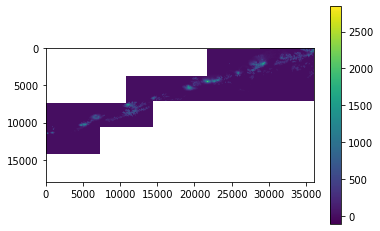

In [8]:
with rasterio.open(vrt_path_0) as ds:
    print(ds.bounds)
    X_0 = ds.read(1)
    p_0 = ds.profile
    
plt.imshow(X_0)
plt.colorbar()

In [9]:
p_0

{'driver': 'VRT', 'dtype': 'float32', 'nodata': nan, 'width': 36002, 'height': 18002, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -170.00041666666667,
       0.0, -0.0002777777777777778, 56.000416666666666), 'blockxsize': 128, 'blockysize': 128, 'tiled': True}

# dem_1

In [10]:
%%time

vrt_path_1 = download_dem(bounds, 
                          dem_1, 
                          f'sample_{dem_1}_{site}',
                          save_raw_tiles=save_raw_tiles,
                          max_workers=5)
vrt_path_1

/Users/cmarshak/bekaert-team/dem-stitcher/dem_stitcher/stitcher.py:119: UserWarning: sample_tdx_30_aleutian exists; data will be overwritten
  # Get tiles to download


CPU times: user 48.3 s, sys: 6.87 s, total: 55.1 s
Wall time: 1min 32s


PosixPath('sample_tdx_30_aleutian/tdx_30.dem.wgs84')

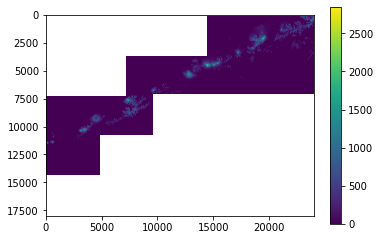

In [11]:
with rasterio.open(vrt_path_1) as ds:
    X_1 = ds.read(1)
    p_1 = ds.profile
    
plt.imshow(X_1)
plt.colorbar()

In [12]:
p_1

{'driver': 'VRT', 'dtype': 'float32', 'nodata': nan, 'width': 24002, 'height': 18002, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00041666666666666664, 0.0, -170.000625,
       0.0, -0.0002777777777777778, 56.000416666666666), 'blockxsize': 128, 'blockysize': 128, 'tiled': True}

# Comparison

In [13]:
X_1_r, _ = reproject_arr_to_match_profile(X_1, p_1, p_0)
X_1_r = X_1_r[0, ...]

Text(0.5, 0, 'tdx_30 - srtm_v3 (m)')

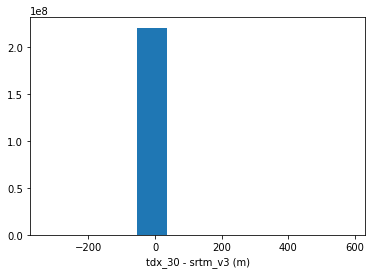

In [14]:
diff = (X_1_r - X_0)
diff_r = diff[~np.isnan(diff)]
plt.hist(diff_r)
plt.xlabel(f'{dem_1} - {dem_0} (m)')

In [15]:
import scipy.stats as stats
import numpy as np

diff_r_ = diff_r.copy()
T = .5

diff_r_ = diff_r_[np.abs(diff_r_) < T]
percent_small = np.sum((np.abs(diff_r_) < T)) / len(diff_r)
print(f'Percent less than {T*100} cm: ', percent_small)
print('these are the stats of the differences')
stats.describe(diff_r_)

Percent less than 50.0 cm:  0.850061497462357
these are the stats of the differences


DescribeResult(nobs=187218220, minmax=(-0.49999952, 0.4999962), mean=-0.0011493842, variance=0.0016801141, skewness=-2.415688991546631, kurtosis=86.33665792877781)

In [16]:
stats.describe(diff_r[~np.isnan(diff_r)])

DescribeResult(nobs=220240795, minmax=(-328.55188, 583.90753), mean=-0.37914225, variance=5.9546275, skewness=4.063015460968018, kurtosis=1628.6283024082397)

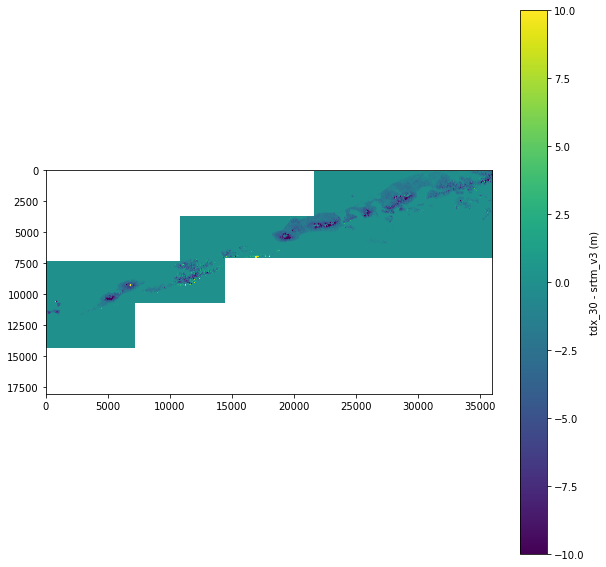

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(diff, vmin=-10, vmax=10)
plt.colorbar(label=f'{dem_1} - {dem_0} (m)')